# Extract data from .SXM
## Author: Jeremiah Croshaw
#### Last Edited: Sept 23 2020

### This code was developed with help from [Moe Rashidi](https://www.linkedin.com/in/moe-rashidi/)
This code was used to speed up exporting images from large collections of .SXM files and allow for post manipulation and filtering to be done using python. This code was developed while Jeremiah was working for the  [Wolkow Group](https://www.robertwolkow.com/). 

author corresponence: croshaw@ualberta.ca

In [1]:
import numpy as np
import os
from os import listdir
import sys
import struct
import scipy.misc
import cv2
import matplotlib.pyplot as plt
from math import sqrt
import math


#### Class SXM
***
__init__(self,filename):
- checks to make sure file exists at filename
- takes headers from SXM and store in dictionary
- decodes data from ascii
***
get_channel(sself, name, direction, corr=None):

inputs:
- self
- name is channel name
- direction is scan direction



In [2]:
class SXM:
    def __init__(self, filename):
        self.filename = filename
        assert os.path.exists(self.filename)
        self.f = open(self.filename, 'rb')
        #extract the header and put them in a dictionary
        l = ''
        key = ''
        self.header = {}
        while l!=b':SCANIT_END:':
            l = self.f.readline().rstrip()
            if l[:1]==b':':
                key = l.split(b':')[1].decode('ascii')
                self.header[key] = []
            else:
                if l: # remove empty lines
                    self.header[key].append(l.decode('ascii').split())
        while self.f.read(1)!=b'\x1a':
            pass
        assert self.f.read(1)==b'\x04'
        assert self.header['SCANIT_TYPE'][0][0] in ['FLOAT','INT','UINT','DOUBLE']
        self.data_offset = self.f.tell()
        self.size = dict(pixels={
                'x': int(self.header['SCAN_PIXELS'][0][0]),
                'y': int(self.header['SCAN_PIXELS'][0][1])
            },real={
                'x': float(self.header['SCAN_RANGE'][0][0]),
                'y': float(self.header['SCAN_RANGE'][0][1]),
                'unit': 'm'
            })
        
    def get_channel(self, name, direction,corr=None):
        chID = 0
        zscale = ''
        for x in self.header['DATA_INFO'][1:]:
            if x[1]==name:
                if x[3]=='both' and direction=='backward':
                    chID += 1
                if x[3]== 'both':
                    break
                return None
                zscale = x[2]
            elif x[3] == 'both':
                chID += 2
            else:
                chID += 1
                    
        size = self.size['pixels']['x']*self.size['pixels']['y']
        self.f.seek(self.data_offset+chID*size*4)
        self.data = np.array(struct.unpack('<>'['MSBFIRST'==self.header['SCANIT_TYPE'][0][1]]+str(size)+{'FLOAT':'f','INT':'i','UINT':'I','DOUBLE':'d'}
        [self.header['SCANIT_TYPE'][0][0]],self.f.read(4*size))).reshape((self.size['pixels']['y'],self.size['pixels']['x']))
        self.CLOSE=self.f.close()

#### normalize(image)
***
input:
- image: 2d array corresponding to scan image

output:
- image: 2d array which has been normalized

In [3]:
def normalize(image):
    image=np.abs(image)
    num_min = np.nanmax(image)
    #print(num_min)
    for x in range(image.shape[0]):
        for y in range(image.shape[1]):
            if np.isnan(image[x][y]): # had to add this to accomodate for incomplete scans
                image[x][y] = num_min
    
    image=image-image.max()
    image=image/image.min()
    #print(image)
    return image

### Main
***
just a simple example of how the images can be extracted

3 sxm files found.


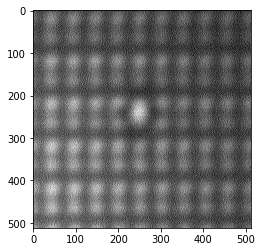

In [4]:
folder_path = ".\\sxm_files" # a few examples are saved here
files = np.asarray(sorted([x for x in os.listdir(folder_path) if x.endswith('.sxm')])) #load filename to array only if it ends with .sxm

num_of_files = files.shape[0]
print(str(num_of_files)+ ' sxm files found.')

#create a directory to save the photos in
if not os.path.exists(folder_path+ "\\images"):
    os.makedirs(folder_path + "\\images")

sxm_dict = SXM(folder_path + '\\' + files[1]) #extracts the SXM data to a dictionary
#print(sxm_dict.header) # check all available data options in header
sxm_dict.get_channel('Current',direction = 'forward') # specify the data channel and the scan direction
plt.imshow(sxm_dict.data,cmap = 'gray')


#### Below is larger version of extraction used for both AFM and STM data
***
For each .SXM file in the folder we look to see if it was an AFM, constant height STM, or constant current STM by looking at if the Z Controller or PLL were on.

For AFM, we extract the forward and backward frequency shift channel.
For constant current STM, we extract the the Z channel, fwd and bwd.
For constant height STM, we extract the current channel, fwd and bwd.

The saved file names for each image have certain details (ie Bias, relative height, etc) in the filename string.  This can be modified to suit your needs

The relative tip height is saved as a comment in the .SXM file from a LabVIEW VI which which runs in the background while operating Nanonis

The image arrays also need to be flipped when comparing forward and backwards as well the up vs down scan direction. These things are done automatically in Nanonis, but the .SXM file just saves things temporally so they need to be flipped.

In [6]:
for x in range(0,num_of_files):
    
    sxm_path = folder_path + '\\' + files[x]
    #print(sxm_path)
    sxm_dict = SXM(sxm_path) #creating a dictionary of the SXM file

    # a sampling of scan parameters that can be extracted
    size_x = float(sxm_dict.header['SCAN_RANGE'][0][0]) 
    size_y = float(sxm_dict.header['SCAN_RANGE'][0][1])
    pixels_x = int(sxm_dict.header['SCAN_PIXELS'][0][0])
    pixels_y = int(sxm_dict.header['SCAN_PIXELS'][0][1]) 
    X_c = float(sxm_dict.header['SCAN_OFFSET'][0][0])
    Y_c = float(sxm_dict.header['SCAN_OFFSET'][0][1])
    angle = float(sxm_dict.header['SCAN_ANGLE'][0][0])*math.pi/180
    Z_ctrl= sxm_dict.header['Z-Controller>Controller status'][0][0]
    
    # PLL is set to TRUE if the phase controller was on during the scan and FALSE if the phase controller was off
    # If there is no dictionary entry, it is set to FALSE.
    if 'Oscillation Control>Phase controller on' in sxm_dict.header:
        PLL = sxm_dict.header['Oscillation Control>Phase controller on'][0][0]
    else:
        PLL = 'FALSE'
    
    # extracting the tip height from the comment (This is added automatically using a VI)
    comment = sxm_dict.header['COMMENT']
    #print('height ->',comment)
    if not comment:
        height = 0.
    #the following elif statements just cover some discrepancies from previous version of the VI. 
    elif comment[0][0] == 'tip': #An older version of the VI started the comment with "tip height"
        if comment[0][1][-2:] == 'pm':#sometimes it was entered in "pm"
            height = float(comment[0][1][6:10])
        else:
            height = float(comment[0][1][6:])*1e12 #sometimes it wasn't.  
    #elif comment[5][0] == 'Zoffset':
    #height = float(comment[5][2])*1e12
    elif comment[0][0][:9] == 'tipheight':#some times it was spelled "tipheight".
        if comment[0][0][10:] == '':
            height = 0.
        else:
            height = float(comment[0][0][10:14])
    else:
        height = float(comment[0][0])*1e3 #this covers the new VI (saved as nm, so we convert to pm)
    
    bias = float(sxm_dict.header['BIAS'][0][0])
    scan_direction = sxm_dict.header['SCAN_DIR'][0][0] 

    #AFM and Const height STM
    #We assume that if the Z_ctrl is OFF and the PLL is ON (TRUE) we are running a constant height fm-AFM (frequency modulated) scan
    if Z_ctrl == 'OFF' and PLL == 'TRUE' :
        print("AFM",files[x])
        sxm_dict.get_channel('OC_M1_Freq._Shift',direction = 'forward')
        image_fwd = sxm_dict.data
        sxm_dict.CLOSE #need to close and reopen to get the backward direction
        sxm_dict = SXM(sxm_path)
        sxm_dict.get_channel('OC_M1_Freq._Shift',direction = 'backward')
        image_bwd = sxm_dict.data
        sxm_dict.CLOSE

        image_fwd = normalize(image_fwd)
        if scan_direction == 'up': #flip array if the scan direction is up
            image_fwd = np.flip(image_fwd,axis = 0)
            image_bwd = np.flip(image_bwd,axis = 0)

        image_bwd = normalize(image_bwd)
        image_bwd = np.flip(image_bwd,axis = 1) # flip the backward direction scan
        
        #write the fwd and bwd scans to the created images folder
        cv2.imwrite(folder_path+ '\\images\\'+files[x][:-4] + '_AFM_fwd_' +str(bias)+'V_' + str(int(round(height,0))) + 'pm.png',image_fwd*255)
        cv2.imwrite(folder_path+ '\\images\\'+files[x][:-4] + '_AFM_bwd_' +str(bias)+'V_' + str(int(round(height,0))) + 'pm.png',image_bwd*255)
        
        #For non-zero imaging biases, it is also possible to collect tunneling current.  This extracts the current channel
        sxm_dict = SXM(sxm_path)
        sxm_dict.get_channel('Current',direction = 'forward')
        image_fwd = sxm_dict.data
        sxm_dict.CLOSE
        sxm_dict = SXM(sxm_path)
        sxm_dict.get_channel('Current',direction = 'backward')
        image_bwd = sxm_dict.data
        sxm_dict.CLOSE

        image_fwd = 1-normalize(image_fwd) #Depending on the sample bias, the current will be positive or negative.
        
        if scan_direction == 'up': # flip if scan direction is up
            image_fwd = np.flip(image_fwd,axis = 0)
            image_bwd = np.flip(image_bwd,axis = 0)

        image_bwd = 1-normalize(image_bwd)
        image_bwd = np.flip(image_bwd,axis = 1) # flip the backward direction scan
        
        #write the fwd and backward current channels to the images folder
        cv2.imwrite(folder_path+ '\\images\\'+files[x][:-4] + '_c-h_fwd_' +str(bias)+'V_' + str(int(round(height,0))) + 'pm.png',image_fwd*255)
        cv2.imwrite(folder_path+ '\\images\\'+files[x][:-4] + '_c-h_bwd_' +str(bias)+'V_' + str(int(round(height,0))) + 'pm.png',image_bwd*255)

    #Const height STM
    #If the Z_ctrl is OFF and the PLL is FALSE we assume we are doing a constant height STM measurement 
    if Z_ctrl == 'OFF' and PLL == 'FALSE' :
        print("c-hSTM",files[x])
        sxm_dict = SXM(sxm_path)
        sxm_dict.get_channel('Current',direction = 'forward')
        image_fwd = sxm_dict.data
        sxm_dict.CLOSE # close and reopen SXM for the backward direction
        sxm_dict = SXM(sxm_path)
        sxm_dict.get_channel('Current',direction = 'backward')
        image_bwd = sxm_dict.data
        sxm_dict.CLOSE

        image_fwd = 1-normalize(image_fwd)
        if scan_direction == 'up': #flip for the up direction
            image_fwd = np.flip(image_fwd,axis = 0)
            image_bwd = np.flip(image_bwd,axis = 0)

        image_bwd = 1-normalize(image_bwd) # inverted so the brightest point is the largest current (depends on sample bias)
        image_bwd = np.flip(image_bwd,axis = 1) #flip for backward direction
        
        #same to images folder
        cv2.imwrite(folder_path+ '\\images\\'+files[x][:-4] + '_c-h_fwd_' +str(bias)+'V_' + str(int(round(height,0))) + 'pm.png',image_fwd*255)
        cv2.imwrite(folder_path+ '\\images\\'+files[x][:-4] + '_c-h_bwd_' +str(bias)+'V_' + str(int(round(height,0))) + 'pm.png',image_bwd*255)

    
    #Constant Current STM
    #If the Z_ctrl is ON, we assume we are doing a constant curent STM measurement.
    if Z_ctrl == 'ON':
        print("c-cSTM",files[x])
        sxm_dict = SXM(sxm_path)
        sxm_dict.get_channel('Z',direction = 'forward')
        image_fwd = sxm_dict.data
        sxm_dict.CLOSE # close and reopen for backward direction
        sxm_dict = SXM(sxm_path)
        sxm_dict.get_channel('Z',direction = 'backward')
        image_bwd = sxm_dict.data
        sxm_dict.CLOSE

        if scan_direction == 'up': #flip for up scan direction
            image_fwd = np.flip(image_fwd,axis = 0)
            image_bwd = np.flip(image_bwd,axis = 0)

        image_fwd = normalize(image_fwd)
        image_bwd = normalize(image_bwd)
        image_bwd = np.flip(image_bwd,axis = 1) # flip for backward scans
        
                
        #save files to images folder
        cv2.imwrite(folder_path+ '\\images\\'+files[x][:-4] + '_c-c_fwd_' +str(bias)+'V_' + str(int(round(height,0))) + 'pm.png',image_fwd*255)
        cv2.imwrite(folder_path+ '\\images\\'+files[x][:-4] + '_c-c_bwd_' +str(bias)+'V_' + str(int(round(height,0))) + 'pm.png',image_bwd*255)


c-cSTM 11-12-2018_011.sxm
c-hSTM 16-02-2019_022.sxm
AFM 20191204_018.sxm
